In [1]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
from PIL import Image
import tensorflow.compat.v1 as tf
import pprint
%matplotlib inline

In [2]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor: shape=(1, 150, 200, 64), dtype=float32, numpy=
array([[[[0.30172518, 0.28211468, 2.4223387 , ..., 1.0978045 ,
          0.69431424, 1.1990573 ],
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         ...,
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         [0.42363834, 0.56422937, 2.929647  , ..., 1.4904122 ,
          0.85025406, 1.33372   ],
         [0.45847642, 0.75582504, 2.4548829 , ..., 1.3755591 ,
          0.82044655, 0.8522244 ]],

        [[0.5808617 , 0.56422937, 2.9793446 , ..., 1.6307087 ,
          0.75949955, 0.6912922 ],
         [0.8020994 , 1.1284587 , 3.6142712 , ..., 2.160086  ,
          0.9419428 , 0.71724075],
         [0.8020994 , 1.1284587 , 3.6142712 , ..., 2.160086  ,
          0.9419428 , 0.71724075],
         ...,
         [0.8

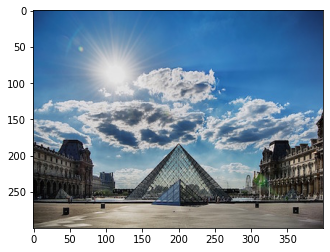

In [3]:
content_image = imageio.imread("~/github/art_generator/images/louvre.jpg")
imshow(content_image);

In [4]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4 * n_H * n_W * n_C) * (tf.reduce_sum(tf.compat.v1.square(tf.subtract(a_C, a_G, name='sub'), name='square'), name='sum'))
    ### END CODE HERE ###
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))



J_content = 7.6410227


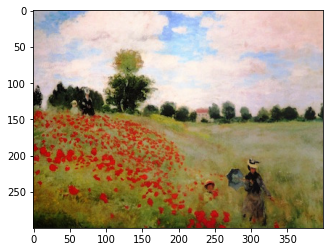

In [6]:
style_image = imageio.imread("images/monet.jpg")
imshow(style_image);

In [7]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A, A, transpose_b = True, name=None)
    ### END CODE HERE ###
    
    return GA

In [8]:
#tf.reset_default_graph()
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = \n" + str(GA.eval()))

GA = 
[[ 15.615461  12.248833 -29.87157 ]
 [ 12.248833  10.877857 -19.879116]
 [-29.87157  -19.879116  67.08007 ]]


In [9]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S, shape=[n_H * n_W, n_C], name=None)
    a_S = tf.transpose(a_S)
    a_G = tf.reshape(a_G, shape=[n_H * n_W, n_C], name=None)
    a_G = tf.transpose(a_G)

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = ((.5 / (n_H * n_W * n_C)) ** 2)*(  tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(GS, GG))))   )
    ### END CODE HERE ###
    
    return J_style_layer



In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 2.2849257


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [13]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha * J_content + beta * J_style
    ### END CODE HERE ###
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


## Start the interactive part

In [15]:
tf.disable_eager_execution() 
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [16]:
content_image = imageio.imread("images/profilbild-1.tif")
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)
content_image.shape

(300, 400, 3)


(1, 300, 400, 3)

In [17]:
style_image = imageio.imread("images/monet.jpg")
style_image = reshape_and_normalize_image(style_image)
style_image.shape

(1, 300, 400, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


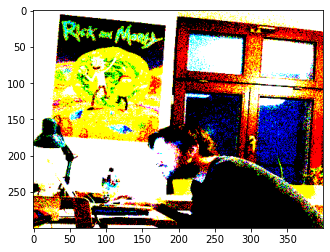

In [18]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [19]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

In [20]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [21]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha=10, beta=40)
### END CODE HERE ###

In [23]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [24]:
def model_nn(sess, input_image, num_iterations = 200):
    
    tf.disable_eager_execution() 
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [25]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 3839323600.0
content cost = 13796.092
style cost = 95979640.0
Iteration 20 :
total cost = 549082050.0
content cost = 20063.713
style cost = 13722035.0
Iteration 40 :
total cost = 297033150.0
content cost = 21805.8
style cost = 7420378.0
Iteration 60 :
total cost = 206518320.0
content cost = 22617.803
style cost = 5157303.5
Iteration 80 :
total cost = 159272530.0
content cost = 23104.303
style cost = 3976037.2
Iteration 100 :
total cost = 129323180.0
content cost = 23549.705
style cost = 3227192.2
Iteration 120 :
total cost = 108379190.0
content cost = 23902.697
style cost = 2703504.2
Iteration 140 :
total cost = 93105064.0
content cost = 24174.824
style cost = 2321582.8
Iteration 160 :
total cost = 81417544.0
content cost = 24419.229
style cost = 2029333.8
Iteration 180 :
total cost = 72122830.0
content cost = 24652.857
style cost = 1796907.6


array([[[[ 83.47683  ,  -6.7285233,  48.945965 ],
         [119.580956 ,   0.6231084, 121.42586  ],
         [ 57.47287  , -12.949335 , 147.71753  ],
         ...,
         [-20.574196 , 106.45302  , 100.48022  ],
         [-35.12174  , 115.210655 , 108.4725   ],
         [-15.10305  , 142.6737   , 165.7964   ]],

        [[116.64974  ,  -5.2709126, 108.96972  ],
         [111.92462  ,  13.545409 , 117.8286   ],
         [ 92.28827  , -21.237597 , 155.0968   ],
         ...,
         [-24.22982  , 107.2967   , 106.91434  ],
         [-16.137852 , 100.83471  ,  90.05247  ],
         [ -7.795144 , 127.370476 , 114.81532  ]],

        [[126.85492  ,   9.470809 ,  37.54633  ],
         [132.26665  ,  12.137651 ,  84.64473  ],
         [100.25259  ,  20.990936 , 127.16444  ],
         ...,
         [ 19.604668 ,  70.92877  , 101.18763  ],
         [ 15.572743 ,  80.77166  , 104.45673  ],
         [  4.9713473,  80.796844 , 109.387314 ]],

        ...,

        [[ -3.5073574, -20.465527 , -3